# **TULLIA'S FIRST PORTFOLIO OPTIMIZATION IN QUANTUM FINANCE PROJECT | IBM Quantum Fall Challenge 2021 SOLUTION**

*Hi there. I'm Tullia Vu. I'm a junior at Foreign Trade University, HCMC. I'm researching about portfolio optimization in quantum finance, I perceived that this sector is blooming and shows prospect. At the same time, I see it is hard for us to find materials to learn so I hope this will help you well. When learning, I found out this challenge but I can't find the answer yet. So that, in this project, I will solve this challenge. If you are interested in this sector, don't hesitate to contact me through: vutrucquynh136@gmail.com*

## *WHAT IS PORTFOLIO OPTIMIZATION ?*

### *WHAT IS PORTFOLIO ?*

Imagine you are investor. You have 100$ in your pocket that you are willing to spend (100$ is called **Budget**) <br>
On the market, there are many stocks such as A,B,C,... <br>
You don't want to put all eggs one basket so you invest 50$ in A, 25$ in B and 25$ in C. (it is called **Diversification**) <br>
And all the diverse assets you possess through investing mentioned above is called **Portfolio**

### *WHY PORTFOLIO NEED TO BE OPTIMIZED ?*

It's commonly said that: "Higher risk, higher return" and you may think risk and return are linearly correlated <br>
However, Harry Markowitz has shown the "curve" shape and you can see that there is still the cases when you get high risk and low return <br>
As a matter of fact, no one want to get high risk and low return. All of us want as much as return and as low as much risk <br>
It is called **Efficient frontier** , you can see the image I attached below

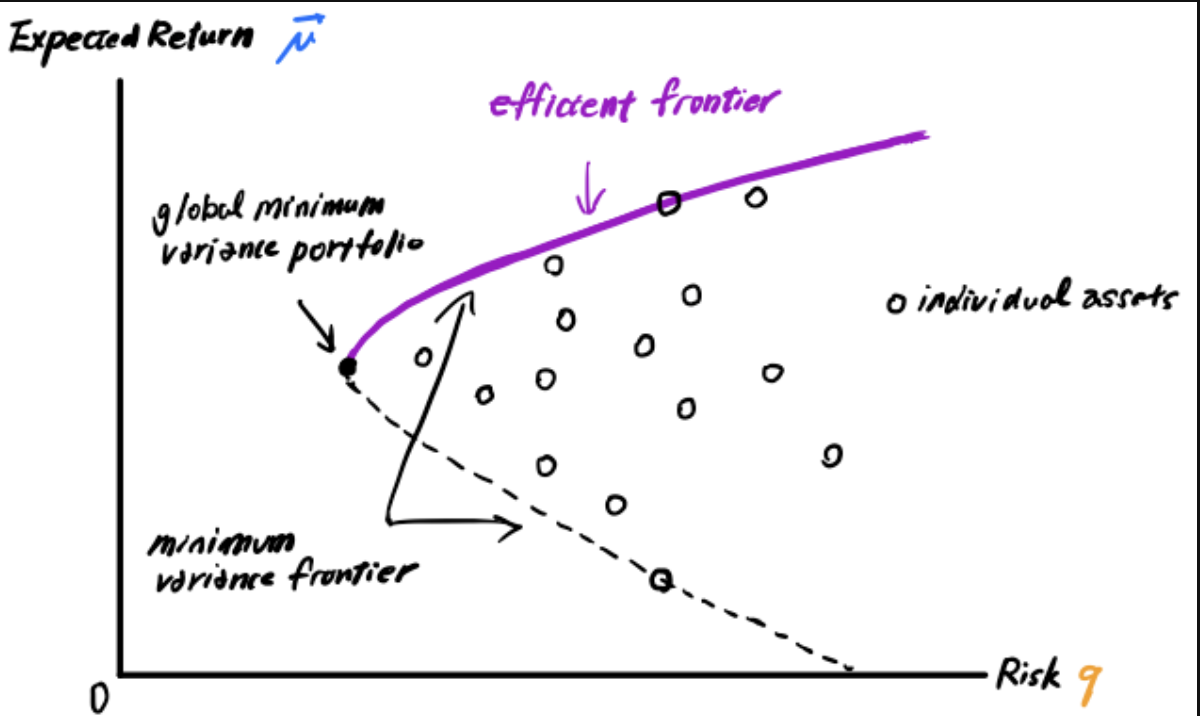

In [9]:
from IPython import display
display.Image("Image1stproject/effiecientfrontier.png")

## *THIS PROJECT'S GOAL*

Find the Efficient Frontier using Quantum approach by Qiskit's Finance. Find x value in the formulation below

## *FORMULATION*

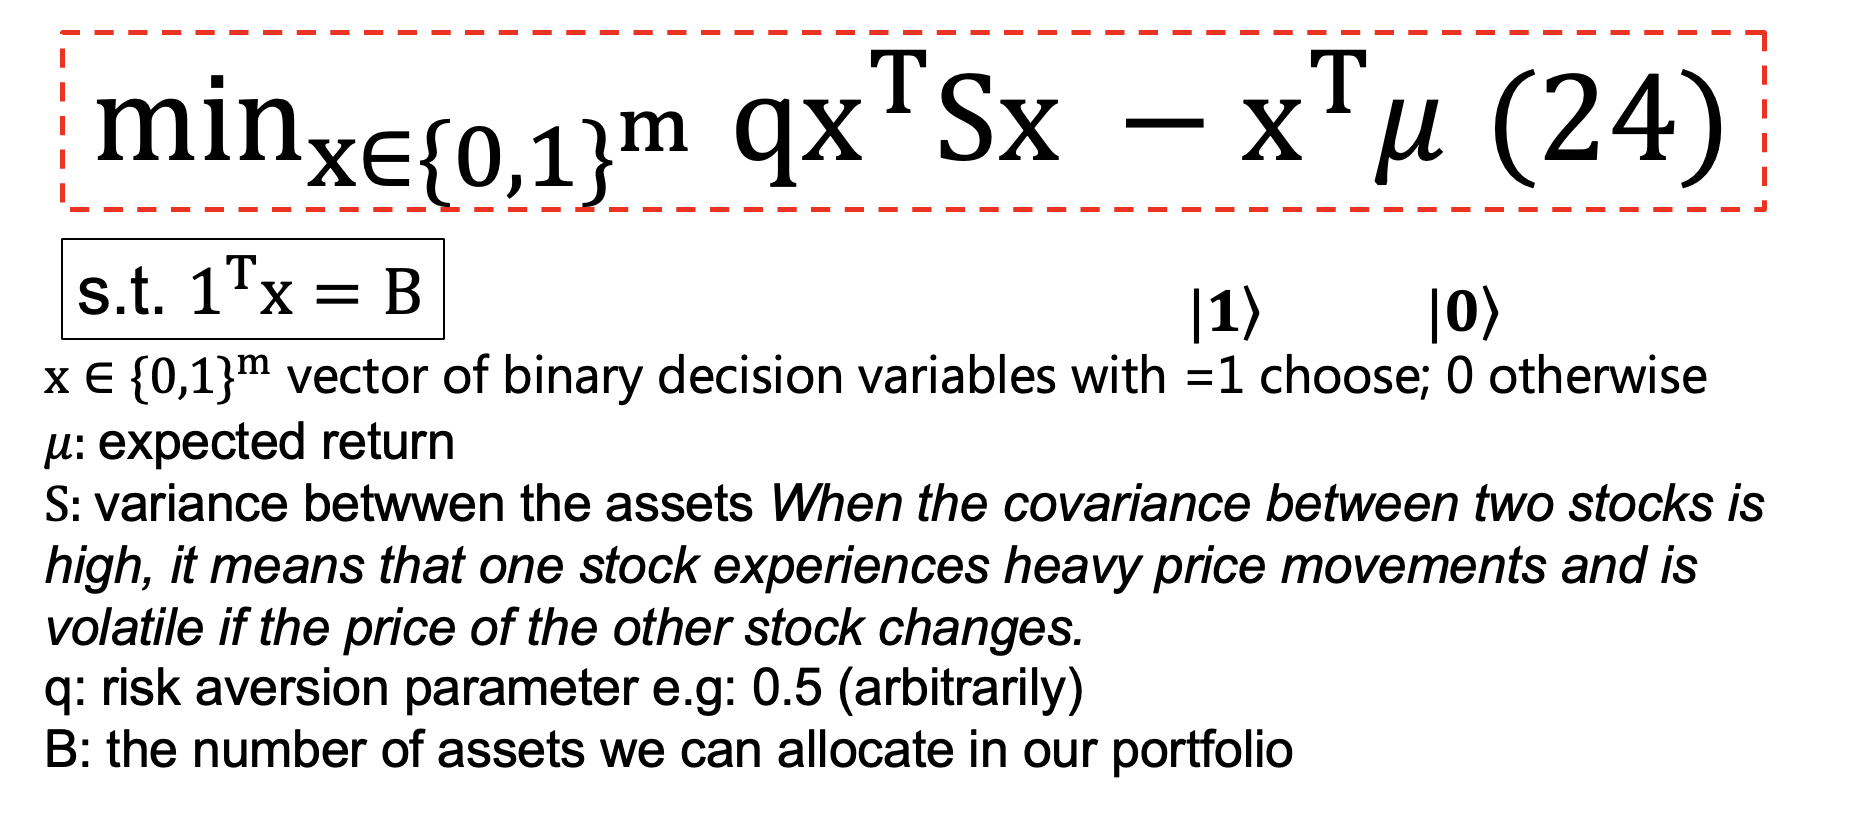

In [1]:
from IPython import display
display.Image("Image1stproject/Mean-variance approach.png")

## *ASSUMPTION*

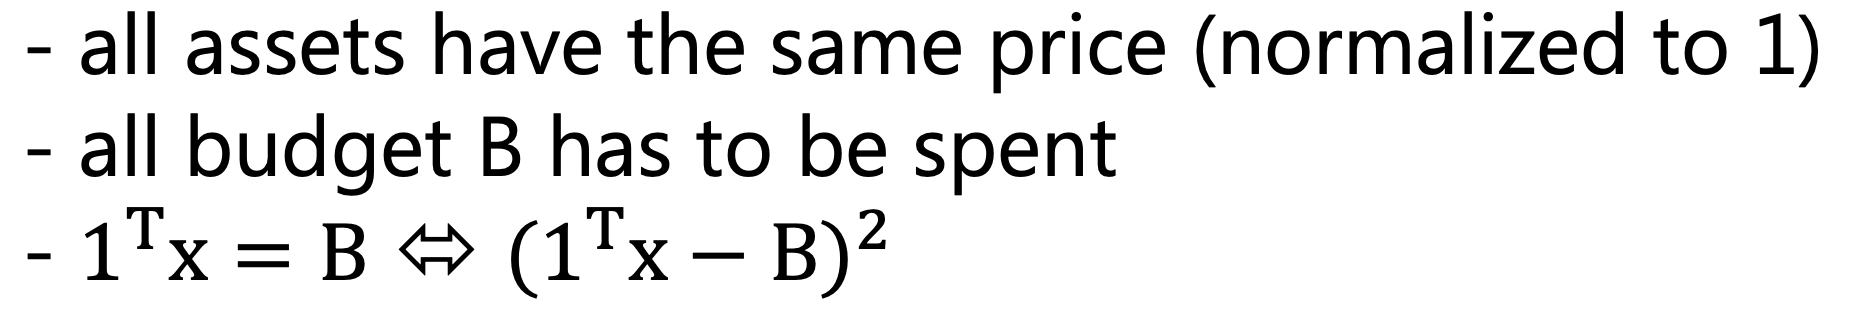

In [7]:
from IPython import display
display.Image("Image1stproject/Assumption.png")

## *LET'S GO !*

### Step 1: Import libararies

In [ ]:
#pip install qiskit  (you should run it in your own terminal)

In [1]:
#pip install qiskit-finance (you should run it in your own terminal)

In [2]:
#pip install matplotlib (you should run it in your own terminal)

In [3]:
#pip install qiskit_algorithms  (you should run it in your own terminal)

In [27]:
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import *
#DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms.
#  The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. 
# Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
import qiskit_algorithms
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit.utils import algorithm_globals
from qiskit_finance import QiskitFinanceError
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_optimization.algorithms import MinimumEigenOptimizer 
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import warnings
from sympy.utilities.exceptions import SymPyDeprecationWarning
warnings.simplefilter("ignore", SymPyDeprecationWarning)

### Step 2: Generate time series data

We have 4 stocks which is STOCK1, STOCK2, STOCK3, STOCK4 <br>
Risk factor is arbitrarily set to 0.5 (the higher the risk averse factor, the more likely that investor want to avoid risk) <br>
Budget = 2 means we will choose 2 out of 4 stocks

In [21]:
# Set parameters for assets and risk factor
num_assets = 4     # set number of assets to 4
q = 0.5                   # set risk factor to 0.5
budget = 2           # set budget as defined in the problem
seed = 132     #set random seed

# Generate time series data
stocks = [("STOCK%s" % i) for i in range(num_assets)]
data = RandomDataProvider(tickers=stocks,
                 start=datetime.datetime(1955,11,5),   
                 end=datetime.datetime(1985,10,26),  
                 seed=seed)
data.run()

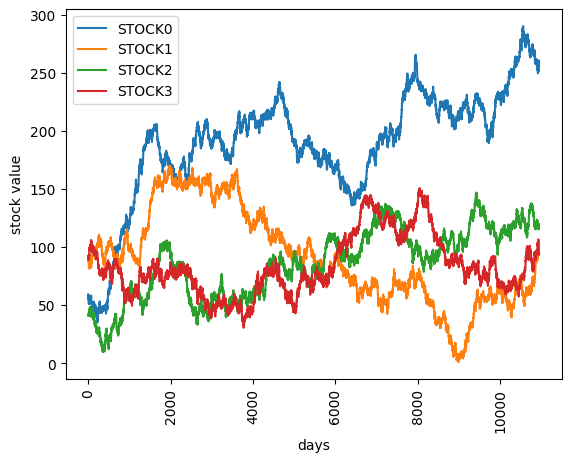

In [22]:
# Let's plot our finanical data
for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('days')
plt.ylabel('stock value')
plt.show()

### Step 3: Quadratic Program Formulation

### Expected Return μ
Expected return of a portfolio is the result of multiplication between posibility and expected return of each asset <br>
P/s: Remember in assumption part, I have assumed that we normalize expected return to 1 <br>
For example, <br>
| Asset | Probability | Expected return |
| --- | --- | --- |
| Stock A | 50% | 0.20 |
| Stock B | 25% | 0.10 |
| Stock C | 25% | 0.15 |

 The **expected return of the portfolio** would be:


<div align="center"> μ = (50% x 20%) + (25% x 10%) + (25% x 15%) = 16.25% </div>

For the problem data we generated earlier, we can calculate the expected return over the 30 years period from 1955 to 1985 by using the following `get_period_return_mean_vector()` method which is provided by Qiskit's RandomDataProvider.

In [6]:
#Let's calculate the expected return for our problem data

mu = data.get_period_return_mean_vector()   # Returns a vector containing the mean value of each asset's expected return.

print(mu)

[1.59702144e-04 4.76518943e-04 2.39123234e-04 9.85029012e-05]


### Covariance Matrix Σ
Covariance Σ demonstrate a relationship between asset's pair. <br>
If you have 'n' stocks in your porfolio, the size of the covariance matrix will be n x n.
Let us plot the covariance marix for our 4 stock portfolio which will be a 4 x 4 matrix. 

[[ 4.88319903e-05 -1.07868619e-06 -2.12961489e-06  7.06600109e-07]
 [-1.07868619e-06  9.97360142e-04  3.51594354e-06  3.68715793e-07]
 [-2.12961489e-06  3.51594354e-06  2.87365468e-04  3.20819120e-06]
 [ 7.06600109e-07  3.68715793e-07  3.20819120e-06  1.92316728e-04]]


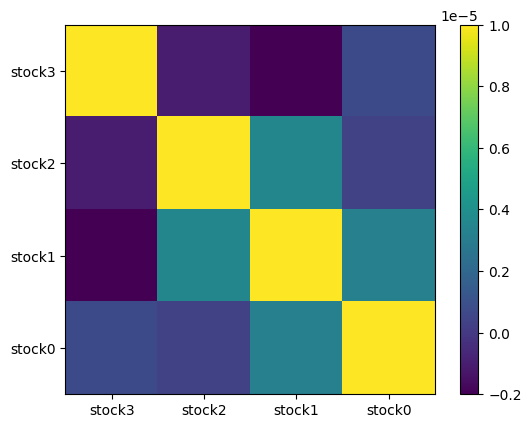

In [23]:
# Let's plot our covariance matrix Σ（sigma）
sigma = data.get_period_return_covariance_matrix() #Returns the covariance matrix of the four assets
print(sigma)
fig, ax = plt.subplots(1,1)
im = plt.imshow(sigma, extent=[-1,1,-1,1])
x_label_list = ['stock3', 'stock2', 'stock1', 'stock0']
y_label_list = ['stock3', 'stock2', 'stock1', 'stock0']
ax.set_xticks([-0.75,-0.25,0.25,0.75])
ax.set_yticks([0.75,0.25,-0.25,-0.75])
ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
plt.colorbar()
plt.clim(-0.000002, 0.00001)
plt.show()

For example, if [1,3] (position 2 in row and 4 in column) = 0,5 <br>
[1,3] cells in matrix means STOCK0 & STOCK1 each other's influence is that : <br>
If the price of STOCK0 increase 1, the price of STOCK1 will increase 0,5 <br>

### WHY COVARIANCE MATRIX IS IMPORTANT ?


If Cov(STOCK0,STOCK1) > 0, which means if an event effects STOCK0 and you lose money, you will lose STOCK1 too. <br>
So investors need to diversify their portfolio (like I have mentioned at the beginning) in a way that those assets he/she possess negatively impact each other to reduce risk

## Qiskit Finance application class

In Qiskit, there is a dedicated [`PortfolioOptimization`](https://qiskit.org/documentation/finance/stubs/qiskit_finance.applications.PortfolioOptimization.html#qiskit_finance.applications.PortfolioOptimization) application to construct the quadratic program for portfolio optimizations.

PortfolioOptimization class creates a porfolio instance by taking the following **five arguments** then converts the instance into a quadratic program.

Arguments of the PortfolioOptimization class:
- expected_returns
- covariances
- risk_factor
- budget
- bounds

Once our portfolio instance is converted into a quadratic program, then we can use quantum variational algorithms suchs as Variational Quantum Eigensolver (VQE) or the Quantum Approximate Optimization Algorithm (QAOA) to find the optimal solution to our problem.<br>

We already obtained expected_return and covariances from Step 3 and have risk factor and budget pre-defined. So, let's build our portfolio using the [`PortfolioOptimization`](https://qiskit.org/documentation/finance/stubs/qiskit_finance.applications.PortfolioOptimization.html#qiskit_finance.applications.PortfolioOptimization) class.


## Challenge 1a: Create the portfolio instance using PortfolioOptimization class
<div id='u-definition'></div>
<div class="alert alert-block alert-success">

**Challenge 1a** <br>
Complete the code to generate the portfolio instance using the [**PortfolioOptimization**](https://qiskit.org/documentation/finance/stubs/qiskit_finance.applications.PortfolioOptimization.html#qiskit_finance.applications.PortfolioOptimization) class. Make sure you use the **five arguments** and their values which were obtained in the previos steps and convert the instance into a quadratic program **qp**. 
</div>

<div id='problem'></div>
<div class="alert alert-block alert-info">
    
**Note:** A binary list [1. 1. 0. 0.] indicates a portfolio consisting STOCK2 and STOCK3.
    
</div>

In [24]:
##############################
# Provide your code here


portfolio = PortfolioOptimization (
    expected_returns = mu, covariances = sigma, risk_factor = q, budget = budget
)
qp = portfolio.to_quadratic_program()

print(qp)

minimize 2.4415995135490737e-05*x_0^2 - 1.0786861899637614e-06*x_0*x_1 - 2.1296148915846148e-06*x_0*x_2 + 7.066001088966939e-07*x_0*x_3 + 0.0004986800708422902*x_1^2 + 3.5159435419629015e-06*x_1*x_2 + 3.6871579302951107e-07*x_1*x_3 + 0.00014368273395849306*x_2^2 + 3.2081912029440247e-06*x_2*x_3 + 9.615836394350563e-05*x_3^2 - 0.00015970214434540012*x_0 - 0.00047651894322521895*x_1 - 0.00023912323435150106*x_2 - 9.850290123158255e-05*x_3 (4 variables, 1 constraints, 'Portfolio optimization')


## Minimum Eigen Optimizer

In [31]:
from nornir.core.task import Result

ModuleNotFoundError: No module named 'nornir'

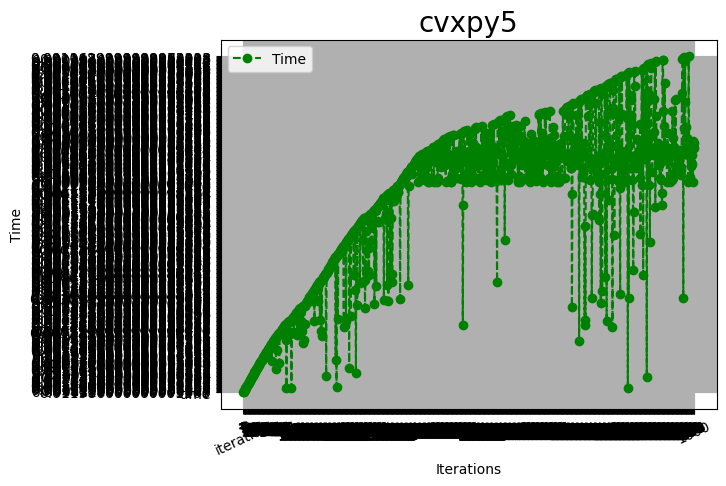

In [9]:
import matplotlib.pyplot as plt 
import csv 
  
x = [] 
y = [] 
  
with open('cvxpy5.csv','r') as csvfile: 
    lines = csv.reader(csvfile, delimiter=',') 
    for row in lines: 
        x.append(row[1]) 
        y.append(row[2])
  
plt.plot(x, y, color = 'g', linestyle = 'dashed', 
         marker = 'o',label = "Time") 
  
plt.xticks(rotation = 25) 
plt.xlabel('Iterations') 
plt.ylabel('Time') 
plt.title('cvxpy5', fontsize = 20) 
plt.grid() 
plt.legend() 
plt.show() 